In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import normaltest, shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import SCORERS, confusion_matrix, classification_report

import random
random.seed(9001)

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# The only think to check before using this class - is there any labels in the test set, that are not existing in train?
# If there are any - this class will create mess in your data! Be careful!

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/DSmentor/EPAM_SPb_DS_course_files/master/3.Classification_1/dataset_57_hypothyroid.csv', na_values = '?')

In [ ]:
data.head()

age sex on_thyroxine  ... TBG referral_source     Class
0  41.0   F            f  ... NaN            SVHC  negative
1  23.0   F            f  ... NaN           other  negative
2  46.0   M            f  ... NaN           other  negative
3  70.0   F            t  ... NaN           other  negative
4  70.0   F            f  ... NaN             SVI  negative

[5 rows x 30 columns]

In [ ]:
a = pandas_profiling.ProfileReport(data)

In [ ]:
a

### Dropping all the bad data:
* Non-representable variables
* Outliers
* Minor Class

Variables __TSH_measured, T3_measured, TT4_measured, T4U_measured, FTI_measured, TBG_measured__ do not bring any useful information, they represent only if particular analysis have been done  
Valuable variables: __TSH, T3, TT4, T4U, FTI, TBG__  
Variable __TBG__ consists only of NAs

In [ ]:
for i in ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']:
    meas = '_'.join([i, 'measured'])
    print('Number of False in {}: {}; Number of NAs {}: {}'.format(meas,sum(data[meas] == 'f'), i, data[i].isna().sum()))

Number of False in TSH_measured: 369; Number of NAs TSH: 369
Number of False in T3_measured: 769; Number of NAs T3: 769
Number of False in TT4_measured: 231; Number of NAs TT4: 231
Number of False in T4U_measured: 387; Number of NAs T4U: 387
Number of False in FTI_measured: 385; Number of NAs FTI: 385
Number of False in TBG_measured: 3772; Number of NAs TBG: 3772


In [ ]:
data.drop(['TBG','TBG_measured','TSH_measured', 'T3_measured', \
           'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', \
           'hypopituitary'], axis = 1, inplace = True)

Split categorical and numerical variables for preprocessing:

In [ ]:
cat_vals = [i for i in data.columns if data.dtypes[i] == 'O']
num_vals = [i for i in data.columns if data.dtypes[i] == 'float64']

In [ ]:
cat_vals

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'referral_source',
 'Class']

In [ ]:
cat_vals.remove('Class')

Numberical variables' distributions:

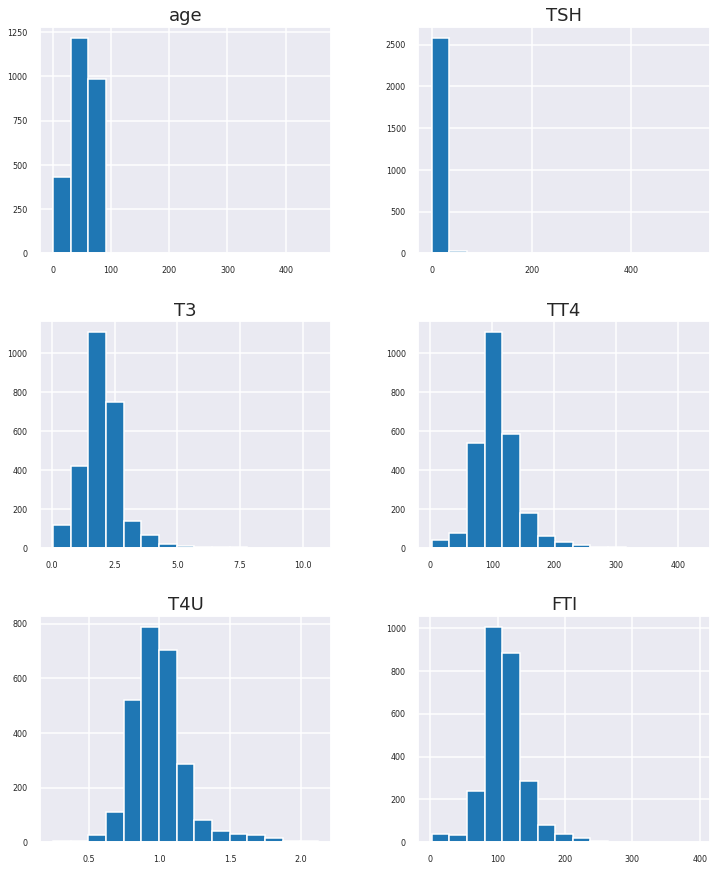

In [ ]:
data.dropna().hist(figsize=(12, 15), bins=15, xlabelsize=8, ylabelsize=8, column = num_vals);

There is outlier in AGE:

In [ ]:
data.age.sort_values(ascending=False)[0:10]

1364    455.0
2673     94.0
1129     94.0
2418     93.0
3014     93.0
2804     92.0
2760     92.0
1490     91.0
1727     91.0
2244     90.0
Name: age, dtype: float64

In [ ]:
data.drop(data[data.age > 100].index, inplace = True)

Distribution of target:  
Class `secondary_hypothyroid` represented only by 2 objects. There's nothing we can do about it, dropping them.  
`Negative` class is overrepresented comparing with `compensated_hypothyroid` and `primary_hypothyroid`.  
Have to remember about this imbalance when evaluating model

In [ ]:
data.Class.value_counts()

negative                   3480
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
data.drop(data[data.Class == 'secondary_hypothyroid'].index, inplace = True)

### Train/Test split

train/test split has to be stratified in case of imbalanced dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class',axis=1), data.Class, test_size=0.2, stratify = data.Class)

In [ ]:
y_train.value_counts()

negative                   2784
compensated_hypothyroid     155
primary_hypothyroid          76
Name: Class, dtype: int64

In [ ]:
y_test.value_counts()

negative                   696
compensated_hypothyroid     39
primary_hypothyroid         19
Name: Class, dtype: int64

### Filling NAs

In [ ]:
X_train[num_vals].count() / X_train[num_vals].shape[0]

age    0.999668
TSH    0.898176
T3     0.794693
TT4    0.936982
T4U    0.894196
FTI    0.894859
dtype: float64

In [ ]:
num_imputer = SimpleImputer(strategy='median')

In [ ]:
X_train[num_vals] = num_imputer.fit_transform(X_train[num_vals])

In [ ]:
X_train[cat_vals].count() / X_train[cat_vals].shape[0]

sex                          0.959867
on_thyroxine                 1.000000
query_on_thyroxine           1.000000
on_antithyroid_medication    1.000000
sick                         1.000000
pregnant                     1.000000
thyroid_surgery              1.000000
I131_treatment               1.000000
query_hypothyroid            1.000000
query_hyperthyroid           1.000000
lithium                      1.000000
goitre                       1.000000
tumor                        1.000000
psych                        1.000000
referral_source              1.000000
dtype: float64

Fill NAs in `sex` variable:

In [ ]:
cat_imputer = SimpleImputer(strategy='constant',fill_value='unknown')
X_train.sex = cat_imputer.fit_transform(X_train.sex.values.reshape(-1, 1))

### Scaling

In [ ]:
X_train.describe()

age          TSH  ...          T4U          FTI
count  3015.000000  3015.000000  ...  3015.000000  3015.000000
mean     51.544279     4.815368  ...     0.991510   109.846567
std      18.954227    24.635897  ...     0.189018    31.362855
min       1.000000     0.005000  ...     0.250000     2.000000
25%      36.000000     0.595000  ...     0.890000    94.000000
50%      54.000000     1.400000  ...     0.970000   107.000000
75%      67.000000     2.400000  ...     1.070000   121.000000
max      94.000000   530.000000  ...     2.320000   395.000000

[8 rows x 6 columns]

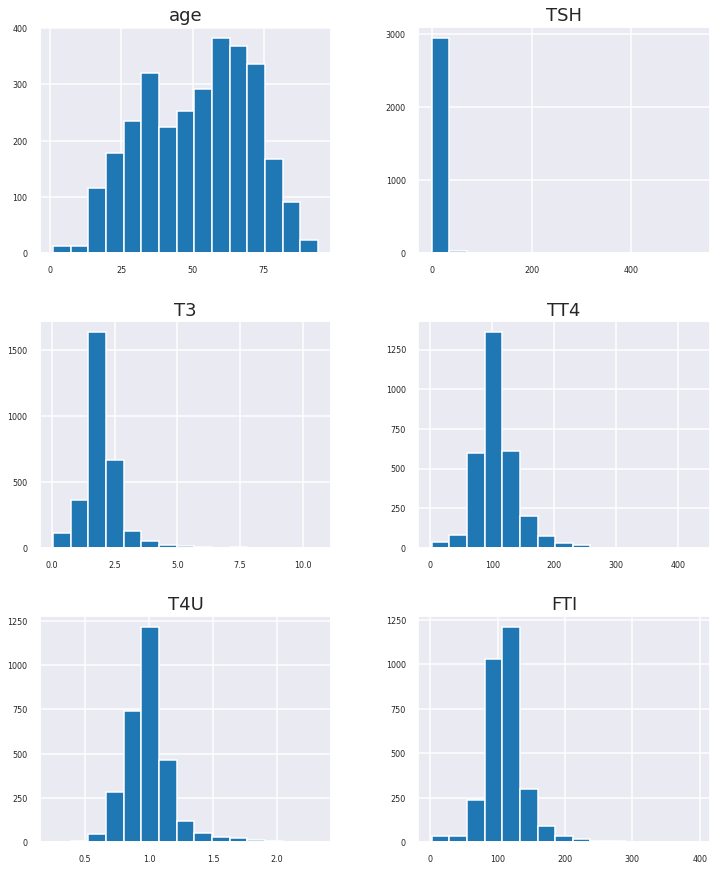

In [ ]:
X_train.hist(figsize=(12, 15), bins=15, xlabelsize=8, ylabelsize=8, column = num_vals);

In [ ]:
vals_to_scale = [x for x in num_vals if x!='TSH']
robust_scaler = RobustScaler()
X_train[vals_to_scale] = robust_scaler.fit_transform(X_train[vals_to_scale])
# for column in num_vals:
#     X_train[column] = robust_scaler.fit_transform(X_train[column].values.reshape(-1, 1))

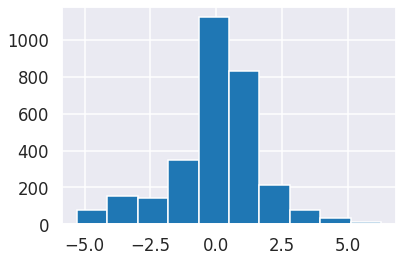

In [ ]:
np.log(X_train.TSH).hist(bins = 10);

In [ ]:
X_train.TSH = np.log(X_train.TSH)

### Pairwise correlation with Class

In [ ]:
training_set = X_train.copy()
training_set['Class'] = y_train

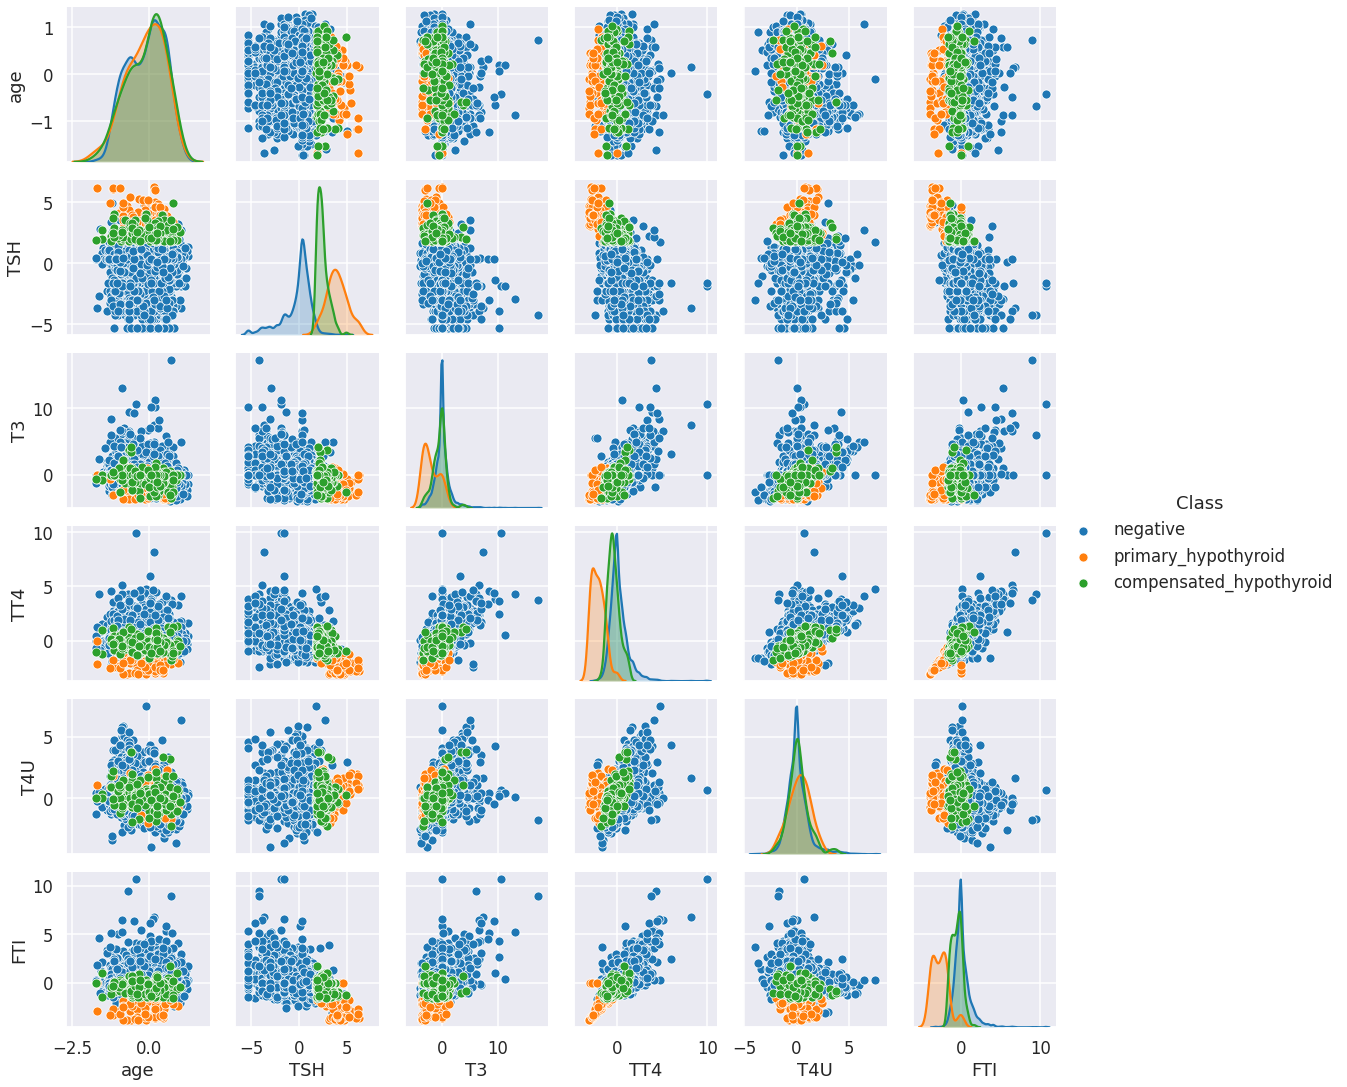

In [ ]:
sns.pairplot(data = training_set, hue = "Class");

### Categorical encoding

In [ ]:
for i in cat_vals:
    print(i,':',len(X_train[i].value_counts()))

sex : 3
on_thyroxine : 2
query_on_thyroxine : 2
on_antithyroid_medication : 2
sick : 2
pregnant : 2
thyroid_surgery : 2
I131_treatment : 2
query_hypothyroid : 2
query_hyperthyroid : 2
lithium : 2
goitre : 2
tumor : 2
psych : 2
referral_source : 5


All categorical variables except for __'sex'__ and __'referral_source'__ have two classes, _LabelEncoder_ is just fine for them
For __'sex'__ and __'referral_source'__ I have to use _OneHotEncoder_

__Label encoding:__

In [ ]:
labelencvars = cat_vals.copy()
labelencvars.remove('sex')
labelencvars.remove('referral_source')

In [ ]:
labelencvars

['on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych']

In [ ]:
#le = LabelEncoder()

In [ ]:
#X_train[labelencvars] = X_train[labelencvars].apply(le.fit_transform)

_LabelEncoder_ is not able to work with several columns at once, need to write own class, which accepts whole df as input. 
So we'll use MultiColumnLabelEncoder define at the beggining of notebook.

In [ ]:
mle = MultiColumnLabelEncoder(columns = cat_vals)

In [ ]:
X_train = mle.fit_transform(X_train)

__One-hot encoding:__

In [ ]:
for i in ['sex', 'referral_source']:
    cols = pd.get_dummies(X_train[i], prefix = i)
    X_train.drop(i, axis = 1, inplace=True)
    X_train = pd.concat([X_train,cols], axis = 1)
#pd.get_dummies(X_train.sex,prefix = 'sex')

### Pipeline

In [ ]:
X_test[num_vals] = num_imputer.transform(X_test[num_vals])
X_test[vals_to_scale] = robust_scaler.transform(X_test[vals_to_scale])
X_test.TSH = np.log(X_test.TSH)

__Categorical variables:__  

In [ ]:
X_test.sex = cat_imputer.transform(X_test.sex.values.reshape(-1, 1))

In [ ]:
X_test = mle.transform(X_test)

In [ ]:
#X_test[labelencvars] = X_test[labelencvars].apply(le.fit_transform)

In [ ]:
for i in ['sex', 'referral_source']:
    cols = pd.get_dummies(X_test[i], prefix = i)
    X_test.drop(i, axis = 1, inplace=True)
    X_test = pd.concat([X_test,cols], axis = 1)

### Baseline model - KNN:

In [ ]:
KNN = KNeighborsClassifier(weights='distance', n_jobs= -1)

### Scoring 
using __F2-measure__ as a score, bc this is medical research so its important not to lose positive class -> recall is important  
also target is heavy imbalanced

In [ ]:
def report(y_test, y_pred):
    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')
    res = fbeta_score(y_test, y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print('\n====classification report:====')
    print(classification_report(y_test, y_pred))

    print('\n====confusion matrix====')
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=confusion_matrix(y_test, y_pred),
                xticklabels=labels,
                yticklabels=labels);
    plt.xticks(rotation=60,horizontalalignment='right')
    plt.ylabel('True')
    plt.xlabel('Predicted')

In [ ]:
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')

In [ ]:
y_pred = KNN.predict(X_test)


====F2 scores:====
                               F2
compensated_hypothyroid  0.631579
negative                 0.988539
primary_hypothyroid      0.777778

====classification report:====
                         precision    recall  f1-score   support

compensated_hypothyroid       0.71      0.62      0.66        39
               negative       0.98      0.99      0.98       696
    primary_hypothyroid       1.00      0.74      0.85        19

               accuracy                           0.97       754
              macro avg       0.89      0.78      0.83       754
           weighted avg       0.96      0.97      0.96       754


====confusion matrix====


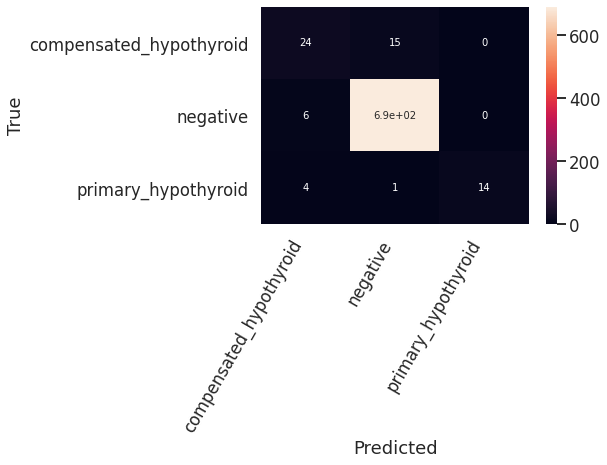

In [ ]:
report(y_test, y_pred)

__First results are not that bad:__  
Numbers of the main diagonal of confusion matrix overhead other ones  
But recall of positive classes should be higher

### Class weights

In [ ]:
logreg = LogisticRegression(class_weight='balanced', multi_class='multinomial')
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
y_pred = logreg.predict(X_test)


====F2 scores:====
                               F2
compensated_hypothyroid  0.874439
negative                 0.968723
primary_hypothyroid      0.851064

====classification report:====
                         precision    recall  f1-score   support

compensated_hypothyroid       0.58      1.00      0.74        39
               negative       1.00      0.96      0.98       696
    primary_hypothyroid       0.89      0.84      0.86        19

               accuracy                           0.96       754
              macro avg       0.82      0.93      0.86       754
           weighted avg       0.98      0.96      0.96       754


====confusion matrix====


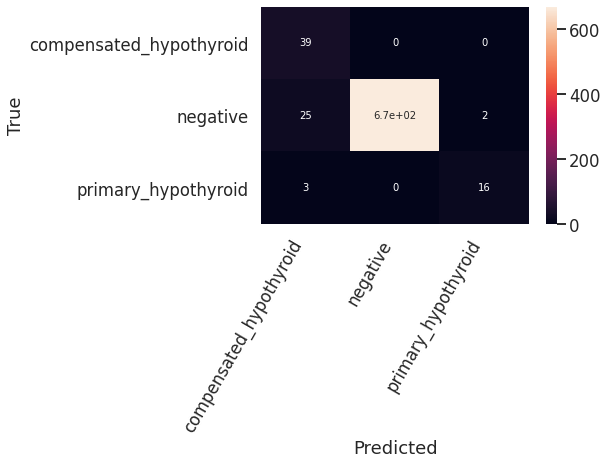

In [ ]:
report(y_test, y_pred)

### Logistic regression with regularization

In [ ]:
f2_score = make_scorer(fbeta_score, beta=2, average='weighted')
logreg_CV = GridSearchCV(estimator = LogisticRegression(multi_class='multinomial'), 
                         param_grid = {'penalty': ['l1','l2'], 'C':[0.001,0.01,0.1,1,10], 
                                       'class_weight':['balanced']},
                        scoring=f2_score, cv = StratifiedKFold(n_splits=5))
logreg_CV.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [ ]:
y_pred = logreg_CV.best_estimator_.predict(X_test)


====F2 scores:====
                               F2
compensated_hypothyroid  0.883721
negative                 0.974552
primary_hypothyroid      0.876289

====classification report:====
                         precision    recall  f1-score   support

compensated_hypothyroid       0.64      0.97      0.78        39
               negative       1.00      0.97      0.98       696
    primary_hypothyroid       0.81      0.89      0.85        19

               accuracy                           0.97       754
              macro avg       0.82      0.95      0.87       754
           weighted avg       0.98      0.97      0.97       754


====confusion matrix====


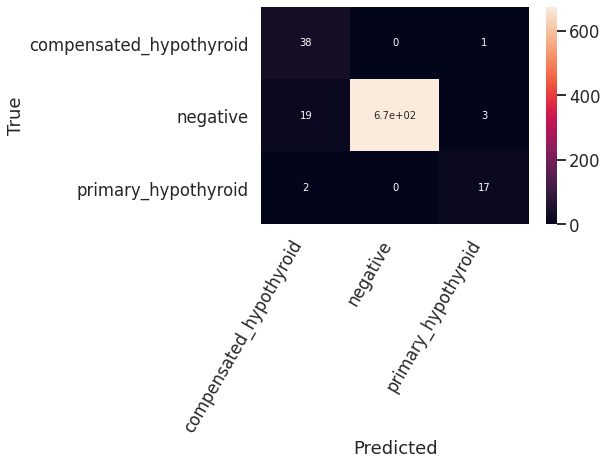

In [ ]:
report(y_test,y_pred)

### Feature importance

In [ ]:
sorted(y_train.unique())

['compensated_hypothyroid', 'negative', 'primary_hypothyroid']

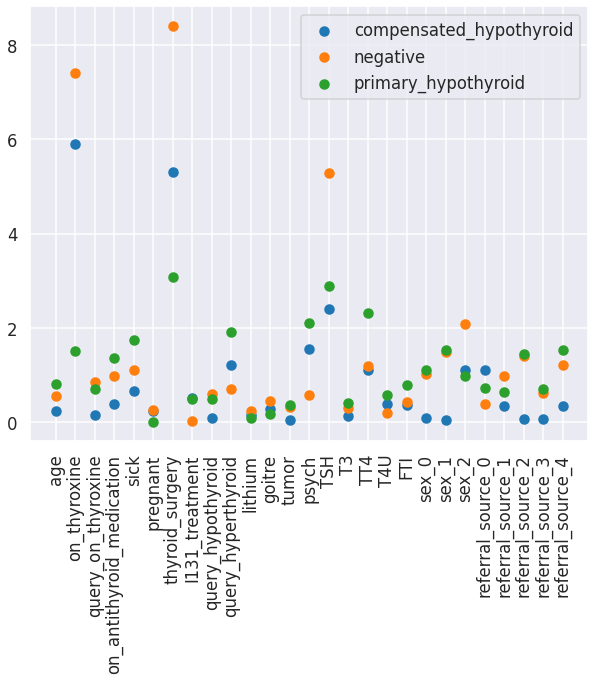

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_CV.best_estimator_.coef_[0]), label = 'compensated_hypothyroid')
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_CV.best_estimator_.coef_[1]), label = 'negative')
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_CV.best_estimator_.coef_[2]), label = 'primary_hypothyroid')
plt.xticks(rotation=90)
plt.legend();

### Conclusion

Best results obtained by Logistic regression:  
Least amount of positive classes (compensated_hypothyroid and primary_hypothyroid) are classified as negative

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
true, pred = [0,1,0,0,1],[0.2,0.534,0,1,0.99]

In [ ]:
log_loss(true, pred)

7.080025863906106

In [ ]:
losses = []
for t, p in zip(true, pred):
  print(log_loss([t,],[p,], labels=[0,1]))
  losses.append(log_loss([t,],[p,], labels=[0,1]))

0.2231435513142097
0.6273594400219421
9.992007221626415e-16
34.53957599234088
0.01005033585350145


In [ ]:
np.mean(losses)

7.080025863906106